In [1]:
from keras.datasets import cifar10, mnist, fashion_mnist
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Input, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

In [0]:
x_train, x_val = x_train.astype('float32')/255.,  x_val.astype('float32')/255.
y_train, y_val = to_categorical(y_train), to_categorical(y_val)

In [0]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect',
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [0]:
train_datagen.fit(x_train)

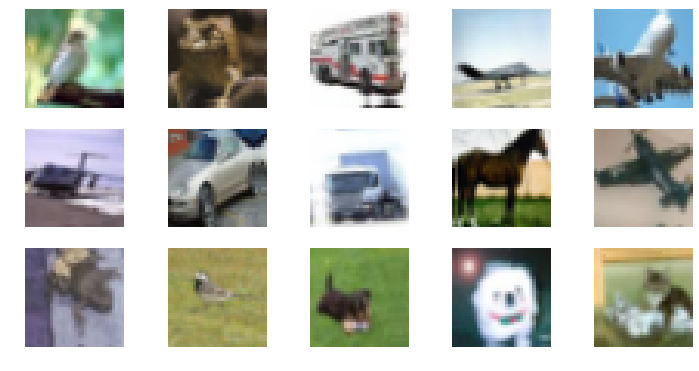

In [6]:
plt.figure(figsize=(10,5))

for X_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=15):
    for i in range(0, 15):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()
    break

In [7]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
bs = 64
epochs = 15

In [9]:
history = model.fit_generator(train_datagen.flow(x_train, y_train,
                              batch_size=bs),
                              epochs=epochs,
                              steps_per_epoch=len(x_train)/bs,
                              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
782/781 [==============================] - 57s 73ms/step - loss: 1.6420 - acc: 0.3993 - val_loss: 1.4715 - val_acc: 0.4862
Epoch 2/15
782/781 [==============================] - 55s 70ms/step - loss: 1.3022 - acc: 0.5349 - val_loss: 1.0791 - val_acc: 0.6185
Epoch 3/15
782/781 [==============================] - 55s 70ms/step - loss: 1.1555 - acc: 0.5910 - val_loss: 1.0047 - val_acc: 0.6499
Epoch 4/15
782/781 [==============================] - 55s 70ms/step - loss: 1.0659 - acc: 0.6280 - val_loss: 0.9669 - val_acc: 0.6695
Epoch 5/15
782/781 [==============================] - 55s 70ms/step - loss: 1.0135 - acc: 0.6436 - val_loss: 0.9308 - val_acc: 0.6791
Epoch 6/15
782/781 [==============================] - 55s 70ms/step - loss: 0.9596 - acc: 0.6670 - val_loss: 0.8674 - val_acc: 0.7016
Epoch 7/15
782/781 [==============================] - 55s 70ms/step - loss: 0.9333 - acc: 0.6742 - val_loss: 0.8448 - val_acc: 0.7094
Epoch 8/15
782

In [15]:
print(f'Baseline accuracy: {model.evaluate(x_val, y_val)[1]}')

10000/10000 [==============================] - 3s 305us/step
Baseline accuracy: 0.7492


### Define the test Image Generator

In [0]:
tta_steps = 10

In [0]:
test_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [25]:
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(test_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    predictions.append(preds)

100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


In [0]:
final_pred = np.mean(predictions, axis=0)

In [27]:
print(f'Accuracy with TTA: {np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(final_pred, axis=-1)))}')

Accuracy with TTA: 0.7833


### See the impact of TTA on a single image

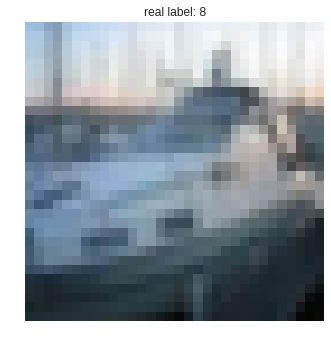

In [28]:
image_ix = 2
test_image = x_val[image_ix]
plt.imshow(test_image)
plt.title(f'real label: {np.argmax(y_val[image_ix])}')
plt.axis('off');

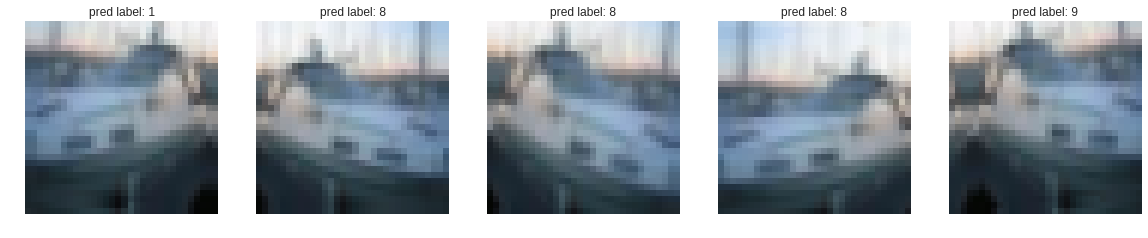

In [32]:
plt.figure(figsize=(20,14))
predictions = []

for i in range(5):
    im = test_datagen.flow(test_image.reshape(1,32,32,3), batch_size=1, shuffle=False)
    im = next(im)
    pred = model.predict(im.reshape(1,32,32,3))
    predictions.append(pred)
    plt.subplot(1, 5, i+1)
    plt.title(f'pred label: {np.argmax(pred)}')
    plt.imshow(im.reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [33]:
final_pred = np.mean(predictions, axis=0)
print(f'final pred: {np.argmax(final_pred)}')

final pred: 8
